<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [11]:
## install required packages
# !pip install swig
# !pip install wrds
# !pip install pyportfolioopt
## install finrl library
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [13]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [14]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [15]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-03-01'

In [16]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [17]:
print(len(config_tickers.DOW_30_TICKER))
print(config_tickers.DOW_30_TICKER)

30
['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [18]:
df.shape

(97013, 8)

In [19]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.496293,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,42.488075,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.551659,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777554,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.934711,7325600,CAT,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

FE Took 33.2 seconds

In [20]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3310, 8)
Successfully added vix
Successfully added turbulence index


In [21]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [22]:
processed_full.sort_values(['date','tic'],ignore_index=True).tail(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
95980,2023-02-27,MRK,110.029999,110.129997,108.519997,108.604942,5654800.0,0.0,0.375003,111.056009,102.319529,53.742948,54.599104,7.835757,107.226522,108.493543,20.950001,7.165849
95981,2023-02-27,MSFT,252.460007,252.820007,249.389999,249.614334,21190000.0,0.0,1.917552,274.542941,241.083489,50.449240,-12.003424,7.400015,251.797808,246.329997,20.950001,7.165849
95982,2023-02-27,NKE,119.260002,119.820000,118.320000,117.805206,4239800.0,0.0,-0.955994,130.247508,116.616675,49.086606,-173.018249,11.474208,124.414547,119.245422,20.950001,7.165849
95983,2023-02-27,PG,139.610001,140.470001,138.529999,138.274292,5820900.0,0.0,-1.365661,142.571560,135.783702,44.799702,-58.348084,12.020575,140.375068,144.898037,20.950001,7.165849
95984,2023-02-27,TRV,185.759995,187.130005,184.440002,183.311630,1195200.0,0.0,-0.586801,188.048076,179.557376,50.112097,-26.332169,3.115712,184.622863,185.252440,20.950001,7.165849
95985,2023-02-27,UNH,488.769989,490.940002,481.959991,481.604645,3006200.0,0.0,-2.169862,502.509064,468.587140,44.597054,-29.616938,1.681637,485.469549,503.708362,20.950001,7.165849
95986,2023-02-27,V,220.729996,221.440002,219.339996,219.921249,4255300.0,0.0,-0.248862,234.257738,218.066569,51.388084,-96.558514,13.228165,225.129226,217.903026,20.950001,7.165849
95987,2023-02-27,VZ,38.990002,39.150002,38.630001,38.247025,14210900.0,0.0,-0.330299,41.607088,37.635474,46.744059,-145.873886,21.951826,39.662597,38.693925,20.950001,7.165849
95988,2023-02-27,WBA,36.049999,36.080002,35.270000,34.859814,5580100.0,0.0,-0.177483,36.576331,34.802832,45.559838,-136.831871,24.613759,35.540877,36.693724,20.950001,7.165849
95989,2023-02-27,WMT,142.710007,143.089996,140.660004,140.329575,5549100.0,0.0,-0.025018,146.576956,138.109340,47.642386,-52.233052,7.250607,141.970265,143.364129,20.950001,7.165849


In [23]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

In [24]:
mvo_df

,date,tic,close
0,2010-01-04,AAPL,6.496293
1,2010-01-04,AMGN,42.488075
2,2010-01-04,AXP,33.551659
3,2010-01-04,BA,43.777554
4,2010-01-04,CAT,40.934711
...,...,...,...
95985,2023-02-27,UNH,481.604645
95986,2023-02-27,V,219.921249
95987,2023-02-27,VZ,38.247025
95988,2023-02-27,WBA,34.859814


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [26]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

85753
10237


In [27]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2956,2021-09-30,UNH,401.489990,403.489990,390.459991,383.180176,3779900.0,3.0,-4.349258,419.212258,386.863771,40.895381,-222.938212,41.980385,405.947462,405.438421,23.139999,24.872063
2956,2021-09-30,V,227.580002,228.789993,222.630005,219.829193,7128500.0,3.0,-1.535732,228.194393,216.108278,44.078995,-54.593352,19.569853,224.339923,231.029018,23.139999,24.872063
2956,2021-09-30,VZ,54.500000,54.509998,54.000000,49.011547,18736600.0,3.0,-0.233667,50.131163,48.744039,41.824887,-102.799154,21.682953,49.605026,50.130593,23.139999,24.872063
2956,2021-09-30,WBA,48.790001,48.930000,46.919998,43.298752,6449400.0,3.0,-0.249741,47.804741,42.944104,44.613726,-107.261034,0.941150,45.199111,44.185759,23.139999,24.872063
2956,2021-09-30,WMT,140.639999,141.729996,139.250000,135.599686,7485900.0,3.0,-1.548950,145.602009,135.119855,40.165845,-151.532157,45.466733,141.806627,140.712201,23.139999,24.872063


In [28]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,141.208954,94639600.0,4.0,-1.701134,155.168216,136.942775,46.927737,-142.198276,41.749873,146.968514,146.067377,21.1,120.123578
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,201.940536,2629400.0,4.0,-3.068378,210.779247,197.515974,40.408585,-96.817140,36.189244,206.532156,215.074070,21.1,120.123578
0,2021-10-01,AXP,168.500000,175.119995,168.479996,170.065353,3956000.0,4.0,2.273327,174.218852,149.232888,56.265096,117.538414,15.667511,161.215662,163.458886,21.1,120.123578
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.123578
0,2021-10-01,CAT,192.899994,195.869995,191.240005,186.913452,3695500.0,4.0,-3.620668,204.625193,180.453266,41.999445,-112.106537,36.203176,195.930337,199.439526,21.1,120.123578


In [29]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [30]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [31]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [32]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [33]:
e_train_gym.action_space

Box(-1.0, 1.0, (29,), float32)

<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [34]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True


### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [21]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


Training the agent took 7 minutes 26.4 seconds

In [22]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

---------------------------------------
| time/                 |             |
|    fps                | 118         |
|    iterations         | 100         |
|    time_elapsed       | 4           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -56.6       |
|    reward             | 0.019704066 |
|    std                | 1           |
|    value_loss         | 2.95        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 118       |
|    iterations         | 200       |
|    time_elapsed       | 8         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0         |
|    learning_rate

In [60]:
trained_a2c.save(r'trained_models/trained_a2c.h5')

### Agent 2: DDPG

In [23]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


Training the agent took 16 minutes 44.3 seconds

In [24]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 2956, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 5993503.47
total_reward: 4993503.47
total_cost: 999.00
total_trades: 35472
Sharpe: 0.945
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 61        |
|    time_elapsed    | 192       |
|    total_timesteps | 11828     |
| train/             |           |
|    actor_loss      | -16.2     |
|    critic_loss     | 303       |
|    learning_rate   | 0.001     |
|    n_updates       | 8871      |
|    reward          | -9.399536 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 54        |
|    time_elapsed    | 430       |
|    total_timesteps | 23656     |
| train/             |           |
|    actor_loss      | -18.2     |
|    critic_loss     | 8.23      |
|    learning_rate   | 0.001     |
|    n_updates       | 20699     |
|

In [59]:
trained_ddpg.save(r'trained_models/trained_ddpg.h5')

### Agent 3: PPO

In [25]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


Training the agent took 5 minutes 16.9 seconds

In [26]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

-----------------------------------
| time/              |            |
|    fps             | 163        |
|    iterations      | 1          |
|    time_elapsed    | 12         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -0.1978175 |
-----------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 2            |
|    time_elapsed         | 24           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0120864855 |
|    clip_fraction        | 0.179        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | 0.00279      |
|    learning_rate        | 0.00025      |
|    loss                 | 4.38         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.

In [58]:
trained_ppo.save(r'trained_models/trained_ppo.h5')

### Agent 4: TD3

In [27]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


Training the agent took 17 minutes 4.5 seconds

In [28]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 63        |
|    time_elapsed    | 186       |
|    total_timesteps | 11828     |
| train/             |           |
|    actor_loss      | 280       |
|    critic_loss     | 2.32e+04  |
|    learning_rate   | 0.001     |
|    n_updates       | 8871      |
|    reward          | -7.996713 |
----------------------------------
day: 2956, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 3781886.39
total_reward: 2781886.39
total_cost: 999.00
total_trades: 38428
Sharpe: 0.686
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 55        |
|    time_elapsed    | 426       |
|    total_timesteps | 23656     |
| train/             |           |
|    actor_loss      | 149       |
|    critic_loss     | 2.19e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 20699     |
|

In [57]:
trained_td3.save(r'trained_models/trained_td3.h5')

### Agent 5: SAC

In [29]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


Training the agent took 19 minutes 32.8 seconds

In [30]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000) if if_using_sac else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 45         |
|    time_elapsed    | 262        |
|    total_timesteps | 11828      |
| train/             |            |
|    actor_loss      | 402        |
|    critic_loss     | 340        |
|    ent_coef        | 0.0972     |
|    ent_coef_loss   | -103       |
|    learning_rate   | 0.0001     |
|    n_updates       | 11727      |
|    reward          | -1.6947685 |
-----------------------------------
day: 2956, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 5530429.26
total_reward: 4530429.26
total_cost: 11861.77
total_trades: 50309
Sharpe: 0.886
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 44         |
|    time_elapsed    | 537        |
|    total_timesteps | 23656      |
| train/             |            |
|    actor_loss      | 186        |
|    critic

In [56]:
trained_sac.save(r'trained_models/trained_sac.h5')

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [31]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [32]:
insample_risk_indicator.vix.describe()

count    2957.000000
mean       18.105293
std         7.272476
min         9.140000
25%        13.370000
50%        16.209999
75%        20.629999
max        82.690002
Name: vix, dtype: float64

In [33]:
insample_risk_indicator.vix.quantile(0.996)

57.212001831054636

In [34]:
insample_risk_indicator.turbulence.describe()

count    2957.000000
mean       34.139586
std        43.879072
min         0.000000
25%        14.613468
50%        23.644134
75%        38.292607
max       652.503538
Name: turbulence, dtype: float64

In [35]:
insample_risk_indicator.turbulence.quantile(0.996)

291.7239811521436

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [36]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [37]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,141.208954,94639600.0,4.0,-1.701132,155.168221,136.942779,46.927731,-142.198298,41.749873,146.968517,146.067376,21.1,120.12354
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,201.940521,2629400.0,4.0,-3.068381,210.779241,197.515982,40.408542,-96.817250,36.189244,206.532156,215.074072,21.1,120.12354
0,2021-10-01,AXP,168.500000,175.119995,168.479996,170.065369,3956000.0,4.0,2.273327,174.218851,149.232891,56.265107,117.538500,15.667511,161.215661,163.458886,21.1,120.12354
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.12354
0,2021-10-01,CAT,192.899994,195.869995,191.240005,186.913452,3695500.0,4.0,-3.620668,204.625181,180.453258,41.999437,-112.106487,36.203176,195.930331,199.439522,21.1,120.12354


In [38]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [39]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [40]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [41]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [42]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [43]:
df_account_value_a2c.shape

(353, 2)

<a id='7'></a>
# Part 6.5: Mean Variance Optimization

In [44]:
mvo_df.head()

,date,tic,close
0,2010-01-04,AAPL,6.496294
1,2010-01-04,AMGN,42.488071
2,2010-01-04,AXP,33.551670
3,2010-01-04,BA,43.777546
4,2010-01-04,CAT,40.934711


In [45]:
fst = mvo_df
fst = fst.iloc[0*29:0*29+29, :]
tic = fst['tic'].tolist()

mvo = pd.DataFrame()

# Create columns in mvo for each ticker.
for k in range(len(tic)):
  mvo[tic[k]] = 0

# Add closing price to each ticker in mvo for its respective date.
for i in range(mvo_df.shape[0]//29):
  n = mvo_df
  n = n.iloc[i*29:i*29+29, :]
  date = n['date'][i*29]
  mvo.loc[date] = n['close'].tolist()

In [46]:
mvo.shape[0]

3310

### Helper functions

In [47]:
from scipy import optimize 
from scipy.optimize import linprog

#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):
    
  #dependencies
  
    
  c = (np.multiply(-1, MeanReturns))
  A = np.ones([PortfolioSize,1]).T
  b=[1]
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
  return res

def MinimizeRisk(CovarReturns, PortfolioSize):
    
  def f(x, CovarReturns):
    func = np.matmul(np.matmul(x, CovarReturns), x.T) 
    return func

  def constraintEq(x):
    A=np.ones(x.shape)
    b=1
    constraintVal = np.matmul(A,x.T)-b 
    return constraintVal
    
  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq})
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)
    
  return opt

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
  def  f(x,CovarReturns):
         
    func = np.matmul(np.matmul(x,CovarReturns ), x.T)
    return func

  def constraintEq(x):
    AEq=np.ones(x.shape)
    bEq=1
    EqconstraintVal = np.matmul(AEq,x.T)-bEq 
    return EqconstraintVal
    
  def constraintIneq(x, MeanReturns, R):
    AIneq = np.array(MeanReturns)
    bIneq = R
    IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
    return IneqconstraintVal
    

  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq},
          {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)
    
  return opt

In [48]:
def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

### Calculate mean returns and variance-covariance matrix

In [49]:
# Obtain optimal portfolio sets that maximize return and minimize risk

#Dependencies
import numpy as np
import pandas as pd


#input k-portfolio 1 dataset comprising 15 stocks
# StockFileName = './DJIA_Apr112014_Apr112019_kpf1.csv'

Rows = 1259  #excluding header
Columns = 15  #excluding date
portfolioSize = 29 #set portfolio size

#read stock prices in a dataframe
# df = pd.read_csv(StockFileName,  nrows= Rows)

#extract asset labels
# assetLabels = df.columns[1:Columns+1].tolist()
# print(assetLabels)

#extract asset prices
# StockData = df.iloc[0:, 1:]
StockData = mvo.head(mvo.shape[0]-336)
TradeData = mvo.tail(336)
# df.head()
TradeData.to_numpy()


array([[147.81156921, 196.99398804, 177.35902405, ...,  48.73966217,
         44.45829773, 144.7155304 ],
       [147.34632874, 195.01158142, 174.4969635 , ...,  48.32645416,
         43.36317062, 143.52861023],
       [151.0287323 , 195.56852722, 171.14485168, ...,  48.48255157,
         43.34476089, 144.42366028],
       ...,
       [149.19363403, 235.3989563 , 174.49356079, ...,  37.90272141,
         35.66752625, 140.97447205],
       [146.50735474, 231.47598267, 173.6068573 , ...,  38.10930634,
         35.26366806, 141.35150146],
       [147.71568298, 232.2585907 , 172.66035461, ...,  38.24702454,
         34.85981369, 140.32957458]])

In [50]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)


#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)


Mean returns of assets in k-portfolio 1
 [0.121 0.063 0.073 0.078 0.069 0.118 0.052 0.043 0.073 0.052 0.106 0.078
 0.022 0.057 0.049 0.073 0.04  0.063 0.046 0.05  0.098 0.096 0.046 0.059
 0.109 0.095 0.042 0.035 0.051]
Variance-Covariance matrix of returns
 [[3.128 1.014 1.29  1.521 1.371 1.689 1.375 1.125 1.088 1.374 1.163 1.221
  1.03  1.525 0.692 1.269 0.664 0.816 1.029 0.733 1.576 1.139 0.668 0.86
  1.144 1.338 0.525 0.908 0.635]
 [1.014 2.4   1.072 1.01  1.066 1.211 1.025 0.965 0.937 1.122 0.978 1.029
  0.851 1.153 0.891 1.14  0.641 0.664 0.906 1.072 1.088 0.873 0.724 0.854
  1.146 1.056 0.631 1.025 0.645]
 [1.29  1.072 3.315 2.475 1.907 1.568 1.428 1.922 1.715 2.237 1.376 1.847
  1.343 1.508 0.861 2.37  0.99  1.075 1.375 0.964 1.357 1.418 0.728 1.505
  1.417 1.8   0.748 1.216 0.584]
 [1.521 1.01  2.475 4.962 2.117 1.687 1.511 2.143 1.838 2.201 1.527 2.121
  1.532 1.699 0.905 2.296 1.117 1.195 1.461 0.949 1.437 1.573 0.748 1.604
  1.472 1.716 0.734 1.362 0.603]
 [1.371 1.066 1.907

In [51]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([268510.,      0.,      0.,      0.,      0.,  67170.,      0.,
            0.,      0.,      0., 328490.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
        80330.,      0.,      0., 249920.,   5570.,      0.,      0.,
            0.])

In [52]:
StockData.tail(1)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2021-10-25,147.138443,196.002777,178.692062,212.869995,195.566635,293.920013,52.642704,106.639709,172.009995,396.093964,...,77.8321,303.287811,161.191162,135.731216,156.46492,440.793518,230.813248,48.280548,45.295742,145.990005


In [53]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1824.88 ,    0.   ,    0.   ,    0.   ,    0.   ,  228.532,
          0.   ,    0.   ,    0.   ,    0.   ,  924.01 ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,  498.352,    0.   ,    0.   ,
        566.977,   24.132,    0.   ,    0.   ,    0.   ])

In [54]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2021-10-26,1.002272e+06
2021-10-27,1.002461e+06
2021-10-28,1.011236e+06
2021-10-29,1.010909e+06
2021-11-01,1.001450e+06
...,...
2023-02-21,9.195315e+05
2023-02-22,9.194654e+05
2023-02-23,9.249119e+05
2023-02-24,9.120102e+05


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [61]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_account_value_a2c.to_csv("df_account_value_a2c.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (354, 8)
Annual return         -0.034876
Cumulative returns    -0.048644
Annual volatility      0.181612
Sharpe ratio          -0.105351
Calmar ratio          -0.158953
Stability              0.280983
Max drawdown          -0.219408
Omega ratio            0.982546
Sortino ratio         -0.146974
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970602
Daily value at risk   -0.022957
dtype: float64


In [78]:
# result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True)
# result = pd.merge(result, df_result_td3, left_index=True, right_index=True)
# result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
# result = pd.merge(result, df_result_sac, left_index=True, right_index=True)
# result = pd.merge(result, MVO_result, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
# result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'mean var', 'dji']


result = pd.DataFrame(index=df_result_a2c.index)
result['a2c'] = df_result_a2c['account_value']
result['ddpg'] = df_result_ddpg['account_value']
result['td3'] = df_result_td3['account_value']
result['ppo'] = df_result_ppo['account_value']
result['sac'] = df_result_sac['account_value']
result['mean var'] = MVO_result['Mean Var']
result['dji'] = df_dji['account_value']

result.to_csv("result.csv")
result

,a2c,ddpg,td3,ppo,sac,mean var,dji
date,,,,,,,
2021-10-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,NaN,1.000000e+06
2021-10-04,9.979159e+05,9.973751e+05,9.973709e+05,9.995713e+05,9.976419e+05,NaN,9.905746e+05
2021-10-05,1.001984e+06,1.000767e+06,1.003053e+06,1.000128e+06,1.001960e+06,NaN,9.996566e+05
2021-10-06,1.005287e+06,1.003075e+06,1.003391e+06,1.000300e+06,1.003211e+06,NaN,1.002637e+06
2021-10-07,1.013821e+06,1.014865e+06,1.014539e+06,1.001608e+06,1.014758e+06,NaN,1.012483e+06
...,...,...,...,...,...,...,...
2023-02-21,9.373986e+05,1.013329e+06,1.072353e+06,8.821094e+05,9.374189e+05,919531.504488,9.651327e+05
2023-02-22,9.368102e+05,1.012778e+06,1.069981e+06,8.800539e+05,9.330225e+05,919465.420392,9.626710e+05
2023-02-23,9.396047e+05,1.016784e+06,1.073759e+06,8.845574e+05,9.344153e+05,924911.935276,9.658412e+05


<Figure size 1500x500 with 0 Axes>

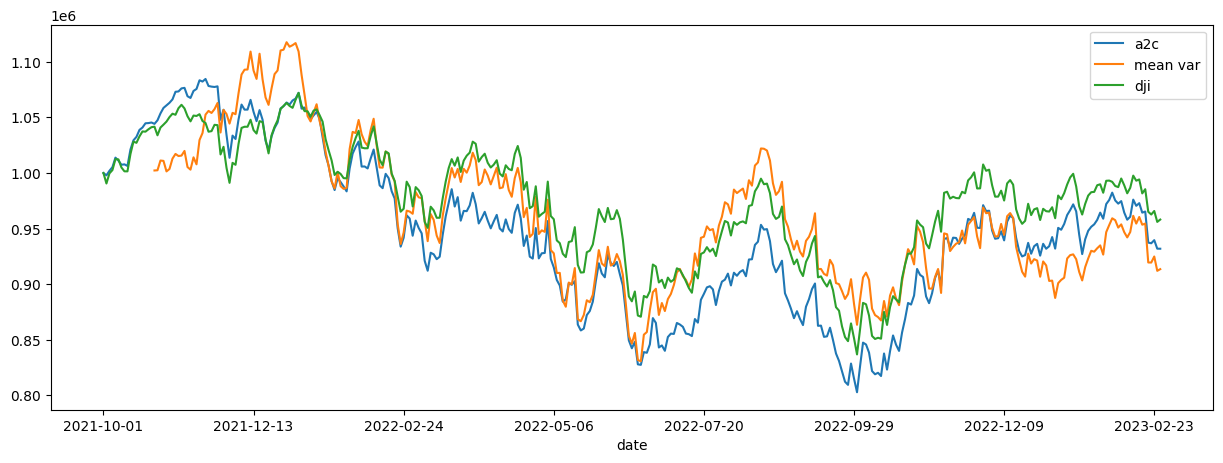

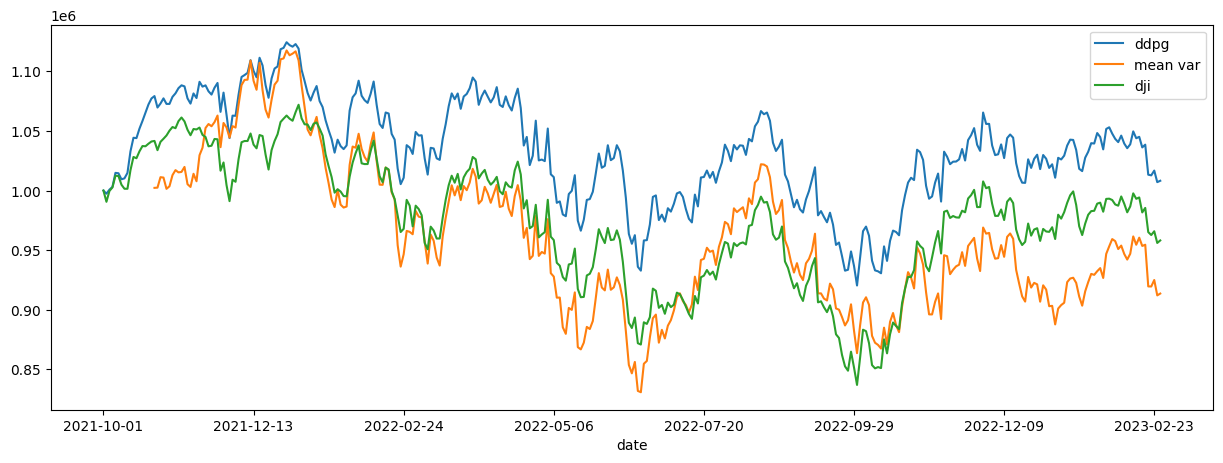

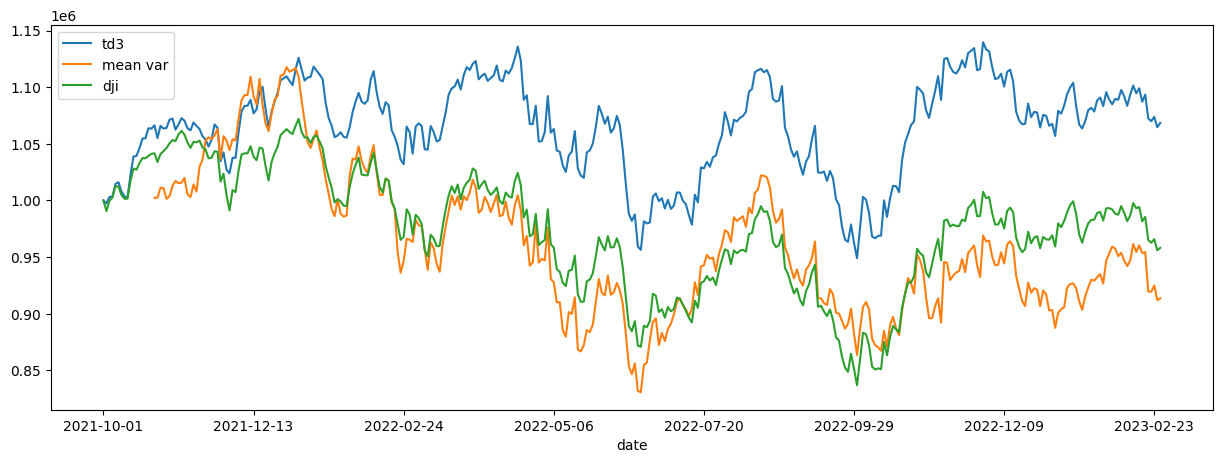

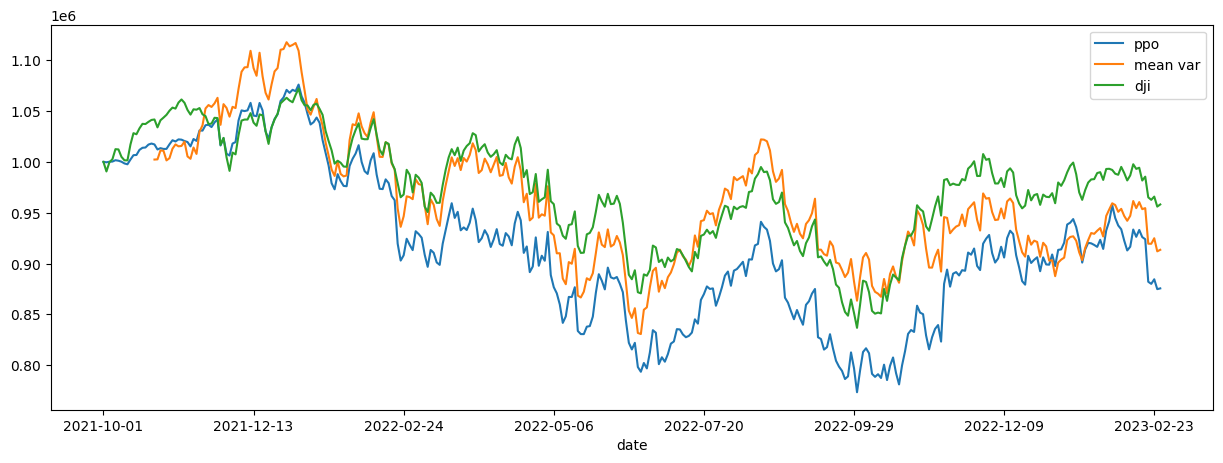

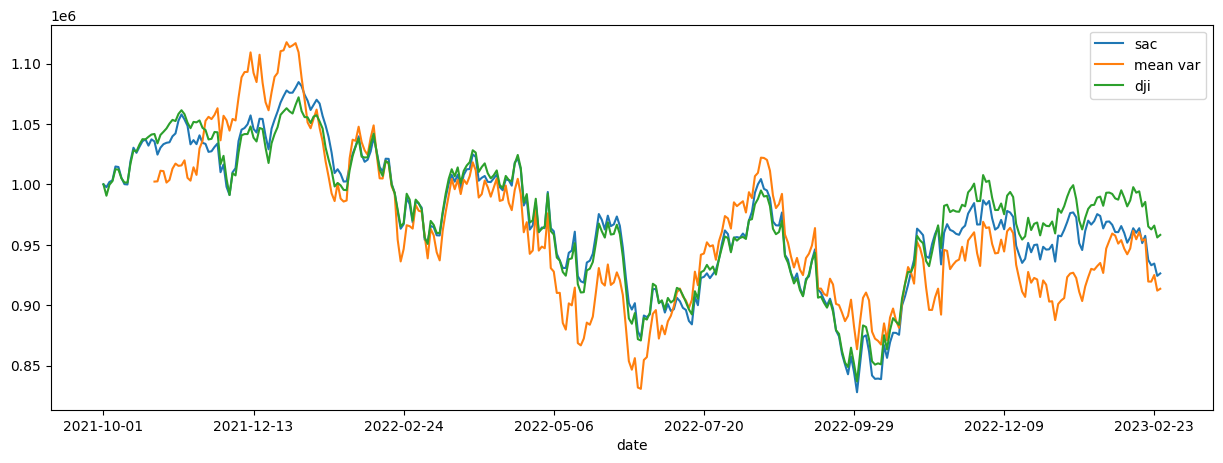

In [119]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();

for i in ['a2c','ddpg','td3','ppo','sac']:
    result[[i,'mean var', 'dji']].plot();